# Assignment 1 - Scott Wilkinson (V00887986) 

## Question 4: KNN Classification

A notebook which uses a KNN classification model to predict if a merging galaxy has already merged with its companion or has not yet merged based on their morphological data.

First, we must import the necessary Python packages.

In [1]:
# importing packages used in notebook
import numpy as np
import matplotlib.pyplot as plt
import pymysql, os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# BTW if you need a package installed, you can use the following

#import os
#os.system('pip install pymysql')

## Importing Morphology Data

In [3]:
#Query SQL for morphology data
# connects to database
db = pymysql.connect(host = 'lauca.phys.uvic.ca', db = 'sdss', user = 'swilkinson', passwd = '123Sdss!@#')
# select morphology params that have unflagged morphology fits
x = 'SELECT  dbID, asymmetry, shape_asymmetry, gini_m20_merger, concentration, outer_asymmetry, deviation, multimode, intensity \
    FROM simCFIS_morph\
    WHERE flag_morph = 0\
    AND asymmetry > -1'
c = db.cursor()
c.execute(x)
db_data = c.fetchall()
c.close()
db.close()

# save names as a string
names_morph = np.array(db_data, dtype = str).T[0]

# save rest of data as floats
morph = np.array(db_data, dtype = float).T[1:]

print(morph.shape)

(8, 219933)


# Merger Sample Selection

## Selecting a Sample of Pre-Merger Galaxies

Here is the reasoning behind my selection cuts:

1.  snap >= 50 requires z<1 in the simulation (ie. enough time for galaxies to form, evolve and begin to merge)
2. rsep > 0 requires there to be two merging galaxies that are not on top of each other yet
3. mass ratio > 0.1, the merger will be significant when it occurs
4. Flaguntilmerger = 1 ensures the merger is true and not a projection effect that confuses the `subfind` code (see Hani et al. 2020, Rodriguez-Gomez et al. 2015)
5. Tuntilmerger < 0.5 ensures the merger will happen soon (< 500 Myr) and the galaxies have begun to gravitationally interact
6. Tpostmerger > 0.5 ensures no recent has occurred that would cause the disturbed morphology

In [4]:
#Query MySQL with reasoning described above
db = pymysql.connect(host = 'lauca.phys.uvic.ca', db = 'IllustrisTNG100_1', user = 'swilkinson', passwd = '123Sdss!@#')
x ='SELECT e.DB_ID, e.Mstar, e.Tuntilmerger, e.MassRatiountilmerger\
    FROM Environment e \
    WHERE snapNum>=50\
    AND rsep>0 \
    AND MassRatiountilmerger>=0.1\
    AND Flaguntilmerger = 1\
    AND Tuntilmerger < 0.5\
    AND Tpostmerger > 0.5'
c = db.cursor()
c.execute(x)
db_data = c.fetchall()
c.close()
db.close()

names_db_pre = np.array(db_data, dtype = str).T[0]
Mstar_pre = np.array(db_data, dtype = float).T[1]
Tum_pre = np.array(db_data, dtype = float).T[2]
mu_pre = np.array(db_data, dtype = float).T[3]

# give time before merger a negative value
Tum_pre *= -1

# differentiate pre-merger galaxies that merge within the next snapshot from post-merger galaxies
#   that have merged within the last snap shot by adding / subtracting 0.1Gyr (approx the middle of a snapshot)
Tum_pre[Tum_pre == 0] = -0.05

# add 0 to match formatting with morphology catalogue
names_db_pre = np.array(['0'+n for n in names_db_pre])

print('There are {} pre-merger galaxies.'.format(len(names_db_pre)))

# match the two catalogues
match, idx_morph_pre, idx_pre = np.intersect1d(names_morph, names_db_pre, return_indices = True)

print('There are {} pre-merger galaxies with flag-free morphology data.'.format(len(names_db_pre[idx_pre])))

There are 7322 pre-merger galaxies.
There are 2886 pre-merger galaxies with flag-free morphology data.


## Selecting a Sample of Post-Merger Galaxies

Here is the reasoning behind my selection cuts:

1. snap >= 50 requires z<1 in the simulation (ie. enough time for galaxies to form, evolve and begin to merge)
2. mass ratio > 0.1, the merger that occurred was significant
3. Flagpostmerger = 1 ensures the merger is true and not a projection effect that confuses the `subfind` code
4. Tpostmerger < 0.5 requires a merger to have occurred in the last 500 Myr
5. rsep > 25 and Tuntilmerger < 0.5 requires there to be no nearby galaxies about to cause another merger in the next 500 Myr

In [5]:
#Query MySQL with the reasoning listed above
db = pymysql.connect(host = 'lauca.phys.uvic.ca', db = 'IllustrisTNG100_1', user = 'swilkinson', passwd = '123Sdss!@#')
x ='SELECT e.DB_ID, e.Mstar, e.Tpostmerger, e.MassRatio\
    FROM Environment e \
    WHERE snapNum>=50\
    AND MassRatio>=0.1\
    AND Flagpostmerger = 1\
    AND Tpostmerger < 0.5\
    AND rsep>25\
    AND Tuntilmerger > 0.5'
c = db.cursor()
c.execute(x)
db_data = c.fetchall()
c.close()
db.close()

names_db_post = np.array(db_data, dtype = str).T[0]
Mstar_post = np.array(db_data, dtype = float).T[1]
Tpm_post = np.array(db_data, dtype = float).T[2]
mu_post = np.array(db_data, dtype = float).T[3]

# add 0 to match formatting with morphology catalogue
names_db_post = np.array(['0'+n for n in names_db_post])

# differentiate pre-merger galaxies that merge within the next snapshot from post-merger galaxies
#   that have merged within the last snap shot by adding / subtracting 0.1Gyr (approx the middle of a snapshot)
Tpm_post[Tpm_post == 0] = 0.05

print('There are {} post-merger galaxies.'.format(len(names_db_post)))

# match with morphology catalogue
match, idx_morph_post, idx_post = np.intersect1d(names_morph, names_db_post, return_indices = True)

print('There are {} post-merger galaxies with flag-free morphology data.'.format(len(names_db_post[idx_post])))

names_db_post = names_db_post[idx_post]#[0:len(Tum_pre[idx_pre])]
Mstar_post = Mstar_post[idx_post]#[0:len(Tum_pre[idx_pre])]
Tpm_post = Tpm_post[idx_post]#[0:len(Tum_pre[idx_pre])]
mu_post = mu_post[idx_post]#[0:len(Tum_pre[idx_pre])]

There are 5153 post-merger galaxies.
There are 3456 post-merger galaxies with flag-free morphology data.


# Preparing Data for Model

In [6]:
# list of all merging galaxies
names_mergers = np.array(list(names_db_pre) + list(names_db_post))
T_merger = np.array(list(Tum_pre) + list(Tpm_post))
mu = np.array(list(mu_pre) + list(mu_post))
mass = np.array(list(Mstar_pre) + list(Mstar_post))

# match catalogues
match, idx_morph, idx_merge = np.intersect1d(names_morph, names_mergers, return_indices = True)

T_merger = T_merger[idx_merge]
morph = morph[:,idx_morph]

In [7]:
# shape of output
print(morph.shape)

(8, 6342)


In [8]:
# shape of output
print(T_merger.shape)

(6342,)


In [9]:
# create training and validation sets (75/25 split)
input_tr,input_va,target_tr, target_va = train_test_split(morph.T, T_merger,test_size=0.25, shuffle = True)


target_tr_orig = target_tr.copy()
target_va_orig = target_va.copy()

# prep for classification, ie. change T_merger to binary; 0 if pre-merger, 1 if post-merger
target_tr[target_tr<0] = 0
target_tr[target_tr>0] = 1
target_va[target_va<0] = 0
target_va[target_va>0] = 1

In [10]:
### normalizing inputs

# fit on training set
scaler = StandardScaler().fit(input_tr)  

# normalize training
input_tr_norm= scaler.transform(input_tr) 

# normalize validation with same scaler & fit
input_va_norm= scaler.transform(input_va)

# K-Nearest Neighbours Classification

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

#https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
 

## First, an initial attempt without optimizing p or k!

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:907: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)


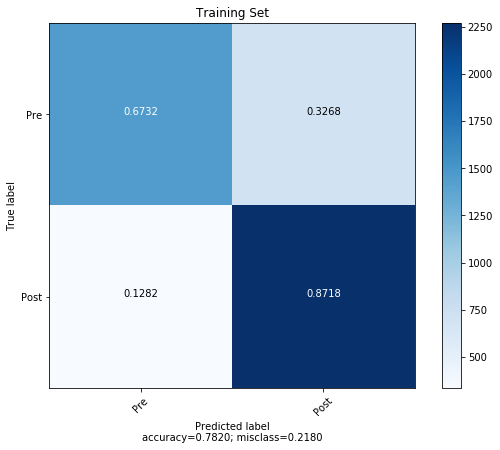

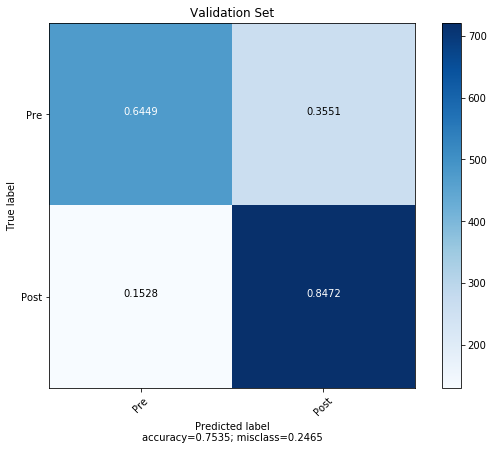

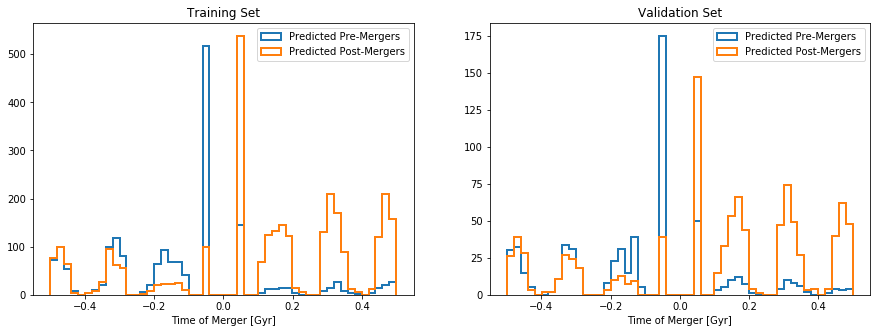

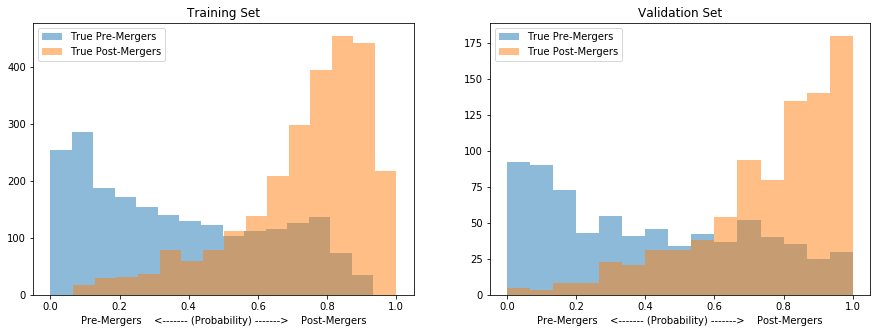

In [12]:
# define hyper parameters
KNN = KNeighborsClassifier(n_neighbors=15, p=2)

# fit the model with training set
KNN.fit(input_tr_norm,target_tr)  

#'predictions for training and validation sets'
target_tr_pred= KNN.predict(input_tr_norm)  
target_va_pred= KNN.predict(input_va_norm)

target_tr_prob = KNN.predict_proba(input_tr_norm)[:,1]
target_va_prob = KNN.predict_proba(input_va_norm)[:,1]

cf_matrix = confusion_matrix(target_tr,target_tr_pred)
plot_confusion_matrix(cf_matrix, target_names = ['Pre','Post'], title = 'Training Set')

cf_matrix = confusion_matrix(target_va,target_va_pred)
plot_confusion_matrix(cf_matrix, target_names = ['Pre','Post'], title = 'Validation Set')

fig, [ax1, ax2] = plt.subplots(1,2,figsize = (15, 5))

ax1.set_title('Training Set')
ax1.hist(target_tr_orig[target_tr_pred == 0], histtype = 'step', lw = 2, bins = 50, label = 'Predicted Pre-Mergers')
ax1.hist(target_tr_orig[target_tr_pred == 1], histtype = 'step', lw = 2, bins = 50, label = 'Predicted Post-Mergers')
ax1.legend(fancybox = True)
ax1.set_xlabel('Time of Merger [Gyr]')

ax2.set_title('Validation Set')
ax2.hist(target_va_orig[target_va_pred == 0], histtype = 'step', lw = 2, bins = 50, label = 'Predicted Pre-Mergers')
ax2.hist(target_va_orig[target_va_pred == 1], histtype = 'step', lw = 2, bins = 50, label = 'Predicted Post-Mergers')
ax2.legend(fancybox = True)
ax2.set_xlabel('Time of Merger [Gyr]')

plt.show()

fig, [ax1, ax2] = plt.subplots(1,2,figsize = (15, 5))

ax1.set_title('Training Set')
ax1.hist(target_tr_prob[target_tr == 0], alpha = 0.5, lw = 2, bins = 15, label = 'True Pre-Mergers')
ax1.hist(target_tr_prob[target_tr == 1], alpha = 0.5, lw = 2, bins = 15, label = 'True Post-Mergers')
ax1.legend(fancybox = True)
ax1.set_xlabel('Pre-Mergers    <------- (Probability) ------->    Post-Mergers')

ax2.set_title('Validation Set')
ax2.hist(target_va_prob[target_va == 0], alpha = 0.5, lw = 2, bins = 15, label = 'True Pre-Mergers')
ax2.hist(target_va_prob[target_va == 1], alpha = 0.5, lw = 2, bins = 15, label = 'True Post-Mergers')
ax2.legend(fancybox = True)
ax2.set_xlabel('Pre-Mergers    <------- (Probability) ------->    Post-Mergers')

plt.show()

Starting with a random p and k, the model seems to be performing fairly well. Certainly better than the KNN Regression model from notebook 1!

# Optimizing p and k using methods from previous notebooks

In [13]:
def run_KNN(k,p):
    
    # define hyper parameters
    KNN = KNeighborsClassifier(n_neighbors=k, p=p)

    # fit the model with training set
    KNN.fit(input_tr_norm,target_tr)  

    #'predictions for training and validation sets'
    target_tr_pred= KNN.predict(input_tr_norm)  
    target_va_pred= KNN.predict(input_va_norm)

    return KNN.score(input_tr_norm, target_tr), KNN.score(input_va_norm, target_va)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:907: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:907: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your cur

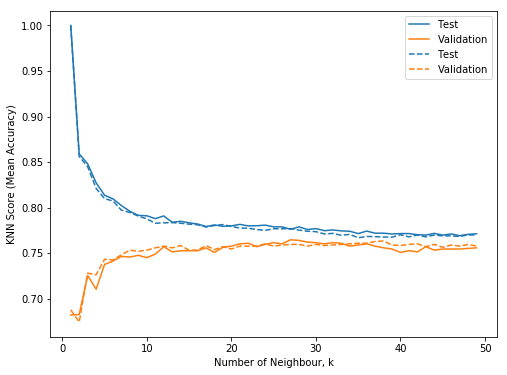

In [14]:

K = np.arange(1,50)
P = [1,2]

fig, ax1 = plt.subplots(1,1, figsize = (8,6))

for p in P:
    
    score_tr, score_va = [],[]
    
    for k in K:
    
        score_tr_tmp, score_va_tmp = run_KNN(k,p)
    
        score_tr.append(score_tr_tmp)
        score_va.append(score_va_tmp)
    
    if p == 2:
        ls = '--'
    else: 
        ls = '-'
    
    ax1.plot(K, score_tr, color = 'tab:blue', label = 'Test', ls = ls)
    ax1.plot(K, score_va, color = 'tab:orange', label = 'Validation', ls = ls)
    ax1.set_xlabel('Number of Neighbour, k')
    ax1.set_ylabel('KNN Score (Mean Accuracy)')
    ax1.legend(fancybox = True)

plt.show()

By iterating over many combinations of p and k, k=29 and p=1 shows exhibits the highest accuracy and is approximately equal performance in the training and validation sets (no overfitting / underfitting).

# Using optimal p and k on normalized data

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:907: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)


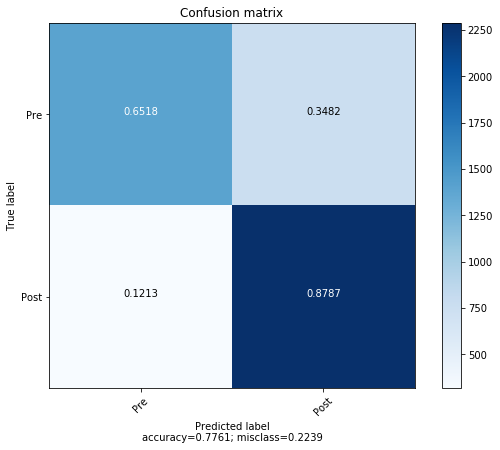

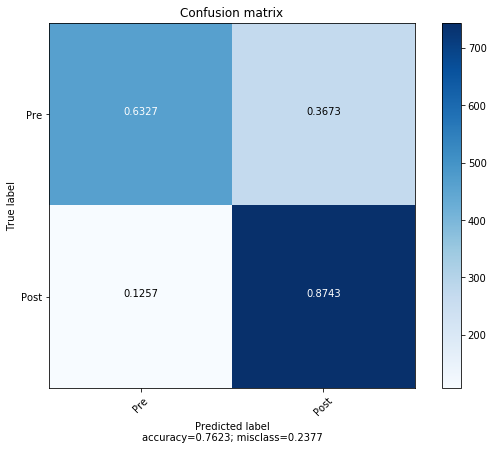

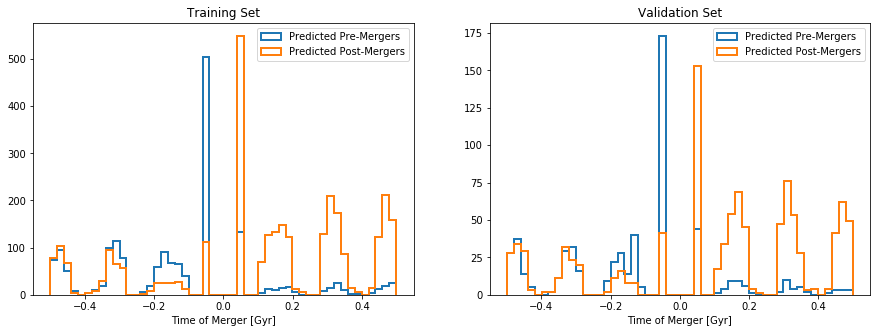

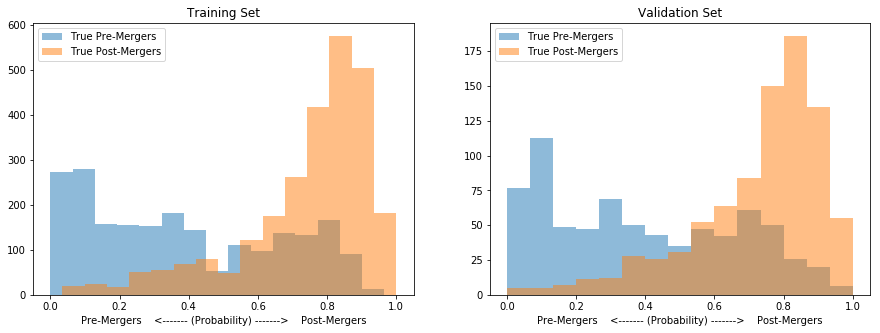

In [15]:
# define hyper parameters
KNN = KNeighborsClassifier(n_neighbors=29, p=1)

# fit the model with training set
KNN.fit(input_tr_norm,target_tr)  

#'predictions for training and validation sets'
target_tr_pred= KNN.predict(input_tr_norm)  
target_va_pred= KNN.predict(input_va_norm)

target_tr_prob = KNN.predict_proba(input_tr_norm)[:,1]
target_va_prob = KNN.predict_proba(input_va_norm)[:,1]

cf_matrix = confusion_matrix(target_tr,target_tr_pred)
plot_confusion_matrix(cf_matrix, target_names = ['Pre','Post'])

cf_matrix = confusion_matrix(target_va,target_va_pred)
plot_confusion_matrix(cf_matrix, target_names = ['Pre','Post'])

fig, [ax1, ax2] = plt.subplots(1,2,figsize = (15, 5))

ax1.set_title('Training Set')
ax1.hist(target_tr_orig[target_tr_pred == 0], histtype = 'step', lw = 2, bins = 50, label = 'Predicted Pre-Mergers')
ax1.hist(target_tr_orig[target_tr_pred == 1], histtype = 'step', lw = 2, bins = 50, label = 'Predicted Post-Mergers')
ax1.legend(fancybox = True)
ax1.set_xlabel('Time of Merger [Gyr]')

ax2.set_title('Validation Set')
ax2.hist(target_va_orig[target_va_pred == 0], histtype = 'step', lw = 2, bins = 50, label = 'Predicted Pre-Mergers')
ax2.hist(target_va_orig[target_va_pred == 1], histtype = 'step', lw = 2, bins = 50, label = 'Predicted Post-Mergers')
ax2.legend(fancybox = True)
ax2.set_xlabel('Time of Merger [Gyr]')

plt.show()


fig, [ax1, ax2] = plt.subplots(1,2,figsize = (15, 5))

ax1.set_title('Training Set')
ax1.hist(target_tr_prob[target_tr == 0], alpha = 0.5, lw = 2, bins = 15, label = 'True Pre-Mergers')
ax1.hist(target_tr_prob[target_tr == 1], alpha = 0.5, lw = 2, bins = 15, label = 'True Post-Mergers')
ax1.legend(fancybox = True)
ax1.set_xlabel('Pre-Mergers    <------- (Probability) ------->    Post-Mergers')

ax2.set_title('Validation Set')
ax2.hist(target_va_prob[target_va == 0], alpha = 0.5, lw = 2, bins = 15, label = 'True Pre-Mergers')
ax2.hist(target_va_prob[target_va == 1], alpha = 0.5, lw = 2, bins = 15, label = 'True Post-Mergers')
ax2.legend(fancybox = True)
ax2.set_xlabel('Pre-Mergers    <------- (Probability) ------->    Post-Mergers')

plt.show()

# Repeat for Un-normalized Data

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:907: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)


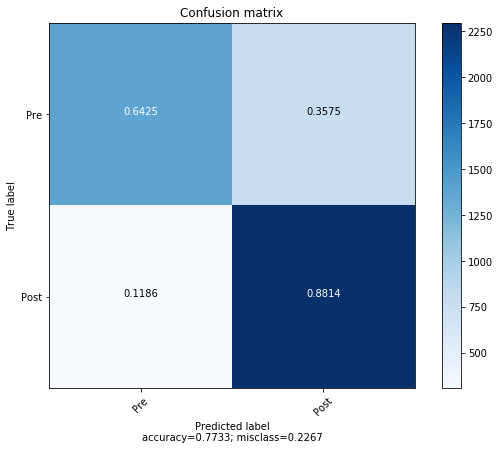

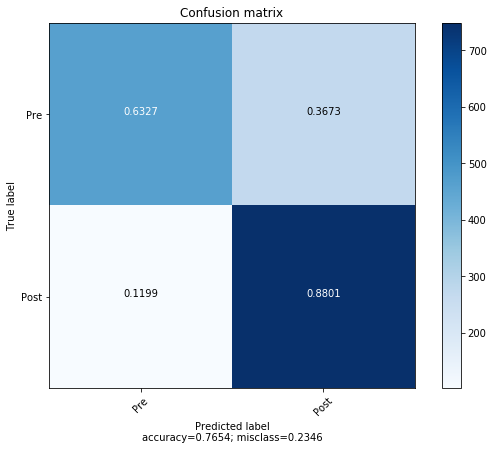

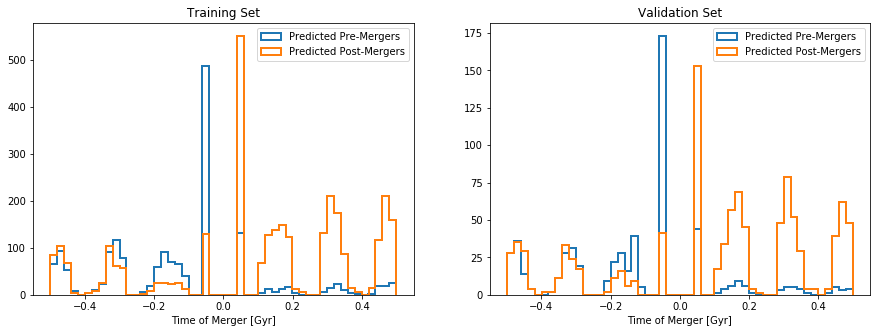

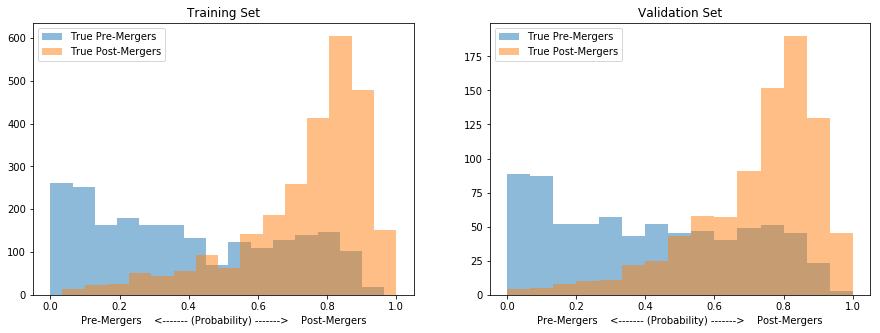

In [16]:
# define hyper parameters
KNN = KNeighborsClassifier(n_neighbors=29, p=1)

# fit the model with training set
KNN.fit(input_tr,target_tr)  

#'predictions for training and validation sets'
target_tr_pred= KNN.predict(input_tr)  
target_va_pred= KNN.predict(input_va)

target_tr_prob = KNN.predict_proba(input_tr)[:,1]
target_va_prob = KNN.predict_proba(input_va)[:,1]

cf_matrix = confusion_matrix(target_tr,target_tr_pred)
plot_confusion_matrix(cf_matrix, target_names = ['Pre','Post'])

cf_matrix = confusion_matrix(target_va,target_va_pred)
plot_confusion_matrix(cf_matrix, target_names = ['Pre','Post'])

fig, [ax1, ax2] = plt.subplots(1,2,figsize = (15, 5))

ax1.set_title('Training Set')
ax1.hist(target_tr_orig[target_tr_pred == 0], histtype = 'step', lw = 2, bins = 50, label = 'Predicted Pre-Mergers')
ax1.hist(target_tr_orig[target_tr_pred == 1], histtype = 'step', lw = 2, bins = 50, label = 'Predicted Post-Mergers')
ax1.legend(fancybox = True)
ax1.set_xlabel('Time of Merger [Gyr]')

ax2.set_title('Validation Set')
ax2.hist(target_va_orig[target_va_pred == 0], histtype = 'step', lw = 2, bins = 50, label = 'Predicted Pre-Mergers')
ax2.hist(target_va_orig[target_va_pred == 1], histtype = 'step', lw = 2, bins = 50, label = 'Predicted Post-Mergers')
ax2.legend(fancybox = True)
ax2.set_xlabel('Time of Merger [Gyr]')

plt.show()


fig, [ax1, ax2] = plt.subplots(1,2,figsize = (15, 5))

ax1.set_title('Training Set')
ax1.hist(target_tr_prob[target_tr == 0], alpha = 0.5, lw = 2, bins = 15, label = 'True Pre-Mergers')
ax1.hist(target_tr_prob[target_tr == 1], alpha = 0.5, lw = 2, bins = 15, label = 'True Post-Mergers')
ax1.legend(fancybox = True)
ax1.set_xlabel('Pre-Mergers    <------- (Probability) ------->    Post-Mergers')

ax2.set_title('Validation Set')
ax2.hist(target_va_prob[target_va == 0], alpha = 0.5, lw = 2, bins = 15, label = 'True Pre-Mergers')
ax2.hist(target_va_prob[target_va == 1], alpha = 0.5, lw = 2, bins = 15, label = 'True Post-Mergers')
ax2.legend(fancybox = True)
ax2.set_xlabel('Pre-Mergers    <------- (Probability) ------->    Post-Mergers')

plt.show()

Using the optimal p and k for the normalized data to classify unnormalized data decreased the accuracy from 0.7654 (for the normalized) to 0.7478 (for the un-normalized). The model does not perform as well for the un-normalized data set but the difference is not very large and is still working reasonably well.